In [1]:
import sys
sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio.Seq import Seq
from functions import params
from functions import data_processing as dp
from functions import general_functions as gf
from functions import lib_table_operations as lto
from importlib import reload
from scipy import stats
from Bio import pairwise2



In [2]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
all_tf_coop = params.ALL_TF_COOP
ed_df = params.MOT_EUC_DIST
RES_PATH = params.RES_PATH

## (A-C) Code for generating the matrices was written in matlab

In [ ]:
# script named 'genome_binding.m'

## (D) Region occupancy for all TFs in all libraries

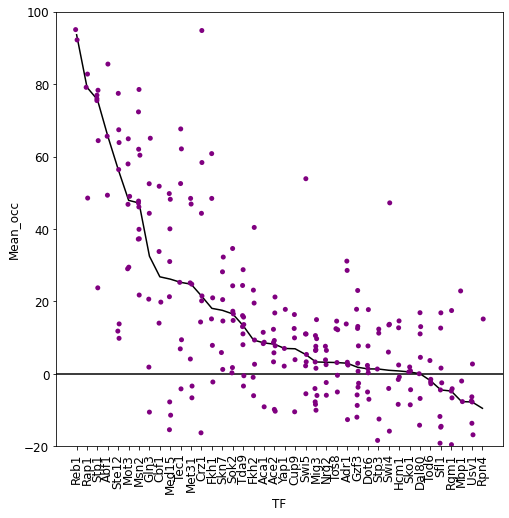

In [5]:
tp = '180'
wanted_exps = [13,14,16,25,26]
to_p = 100
all_tfs = np.unique([file.split('_')[0] for file in os.listdir(params.RES_PATH)])
matchers = ['OE','DBD','Context']
matching = [s for s in all_tfs if any(xs in s for xs in matchers)]
wanted_tfs = [x for x in all_tfs if x not in matching]
reg_occ = pd.DataFrame()
for curr_tf in wanted_tfs:
    tf_files = [file for file in dp.find_tf_files(curr_tf) if int(file.split('.')[0].split('_')[2]) in wanted_exps]
    lib_nums = list(set([file.split('.')[0].split('_')[1] for file in tf_files]))
    for curr_lib in lib_nums:
        lib_info = dp.get_lib_info(curr_lib)
        wt_seq = ''.join(lib_info['wt_at_var_loc'])
        lib_files = [i for i in tf_files if i.split('.')[0].split('_')[1]==str(curr_lib)]
        curr_exps = [i.split('.')[0].split('_')[2] for i in lib_files]
        if len(lib_files)>1:
            rep_occ = lto.convert_fc_to_occ(lto.combine_2_exps(curr_tf, curr_lib, tp, curr_exps, norm_to=None)).loc[wt_seq]*to_p
        else:
            file_name = curr_tf + '_' + str(curr_lib) + '_' + str(curr_exps[0]) + '.csv'  # looking for the relevant results file based on our system ('tf_libnum_exp.csv')
            norm_df = dp.norm_reads(pd.read_csv(os.path.join(RES_PATH, file_name), index_col=0))  # reading current result table into pd dataframe                        
            sample_filt_norm, _ = dp.rm_samples(curr_tf, curr_lib, curr_exps[0], norm_df)
            sample_info = dp.get_samp_info(sample_filt_norm)
            log2_norm = dp.res_log2(sample_filt_norm)
            norm_tp_0 = dp.norm_to_tp_0(log2_norm, sample_info)
            norm_uncut = lto.norm_non_cut(curr_lib, norm_tp_0, None)
            rep_occ = lto.convert_fc_to_occ(norm_uncut.loc[wt_seq,norm_uncut.columns.str.contains(tp)])*to_p
        reg_occ = pd.concat([reg_occ,pd.DataFrame([curr_tf,curr_lib,rep_occ.mean(),rep_occ.sem()]).T])
reg_occ.columns = ['TF','Lib','Mean_occ','Sem']   
order = reg_occ.groupby(by='TF').median().sort_values('Mean_occ',ascending=False).index
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.stripplot(data=reg_occ,x='TF',y='Mean_occ',color='purple',order=order,ax=ax,zorder=20)
plt.xticks(rotation=90)
plt.axhline(0,c='k')
plt.plot(reg_occ.groupby(by='TF').median().loc[order]['Mean_occ'],c='k')
plt.ylim(-20,100)
plt.show()
thresh = 10
n_tf_p = np.sum(reg_occ.groupby('TF')['Mean_occ'].max()>thresh)
n_tf_np = np.sum(reg_occ.groupby('TF')['Mean_occ'].max()<=thresh)

## (E) %Occupancy on tf motifs (intact vs mut) and %Occ of non tf_motifs

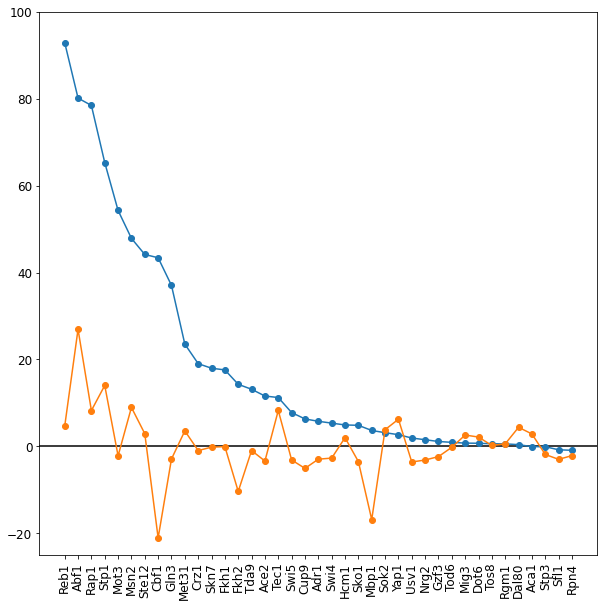

In [4]:
tp = '180'
wanted_exps = [13,14,16,25,26]
to_p = 100
all_tfs = np.unique([file.split('_')[0] for file in os.listdir(params.RES_PATH)])
matchers = ['OE','DBD','Context','Med15']
matching = [s for s in all_tfs if any(xs in s for xs in matchers)]
wanted_tfs = [x for x in all_tfs if x not in matching]
mot_occ = pd.DataFrame()
for curr_tf in wanted_tfs:
    tf_files = [file for file in dp.find_tf_files(curr_tf) if int(file.split('.')[0].split('_')[2]) in wanted_exps]
    lib_nums = list(set([file.split('.')[0].split('_')[1] for file in tf_files]))
    for curr_lib in lib_nums:
        lib_info = dp.get_lib_info(curr_lib)
        lib_files = [i for i in tf_files if i.split('.')[0].split('_')[1]==str(curr_lib)]
        curr_exps = [i.split('.')[0].split('_')[2] for i in lib_files]
        if len(curr_exps)>1:
            rep_occ = lto.combine_2_exps(curr_tf, curr_lib, tp, curr_exps, norm_to=0)
            tf_on,tf_off,_,_,non_tf_on,non_tf_off = lto.get_all_tf_motifs_wt_or_mut(curr_tf,lib_info,rep_occ.index)
            curr_tf_mots_sig = lto.convert_fc_to_occ((rep_occ.iloc[tf_on,:].mean()-rep_occ.iloc[tf_off,:].mean()).mean())*to_p
            curr_non_tf_mots_sig = lto.convert_fc_to_occ((rep_occ.iloc[non_tf_on,:].mean()-rep_occ.iloc[non_tf_off,:].mean()).mean())*to_p

        else:
            file_name = curr_tf + '_' + str(curr_lib) + '_' + str(curr_exps[0]) + '.csv'  # looking for the relevant results file based on our system ('tf_libnum_exp.csv')
            res_table = (pd.read_csv(os.path.join(params.RES_PATH, file_name), index_col=0))  # reading current result table into pd dataframe           
            norm_df = dp.norm_reads(res_table)
            sample_filt_norm,_ = dp.rm_samples(curr_tf, curr_lib, curr_exps[0], norm_df)
            sample_info = dp.get_samp_info(sample_filt_norm)
            log2_norm = dp.res_log2(sample_filt_norm)
            norm_tp_0 = dp.norm_to_tp_0(log2_norm, sample_info)
            rep_occ = lto.norm_non_cut(curr_lib, norm_tp_0, 0)
            tf_on,tf_off,_,_,non_tf_on,non_tf_off = lto.get_all_tf_motifs_wt_or_mut(curr_tf,lib_info,rep_occ.index)
            curr_tf_mots_sig = lto.convert_fc_to_occ((rep_occ.iloc[tf_on,:].mean().iloc[rep_occ.columns.str.contains(tp)] - 
                                rep_occ.iloc[tf_off,:].mean().iloc[rep_occ.columns.str.contains(tp)]).mean())*to_p
            curr_non_tf_mots_sig = lto.convert_fc_to_occ((rep_occ.iloc[non_tf_on,:].mean().iloc[rep_occ.columns.str.contains(tp)] - 
                                rep_occ.iloc[non_tf_off,:].mean().iloc[rep_occ.columns.str.contains(tp)]).mean())*to_p
        mot_occ = pd.concat([mot_occ,pd.DataFrame([curr_tf,curr_lib,curr_tf_mots_sig,curr_non_tf_mots_sig]).T],axis=0)
mot_occ.columns = ['TF','Lib','mot_on','mot_off']   
fig,ax = plt.subplots(1,1,figsize=(10,10))
order = mot_occ.groupby('TF').median().sort_values('mot_on',ascending=False).index
plt.xticks(rotation=90)
plt.axhline(0,c='k')
plt.ylim(-25,100)
plt.plot(mot_occ.groupby('TF').median().sort_values('mot_on',ascending=False)['mot_on'],marker='o')
plt.plot(mot_occ.groupby('TF').median().sort_values('mot_on',ascending=False)['mot_off'],marker='o')
plt.xticks(rotation=90)
plt.show()

## (F) Independent recruitment by other TF motifs 

(0.0, 60.0)

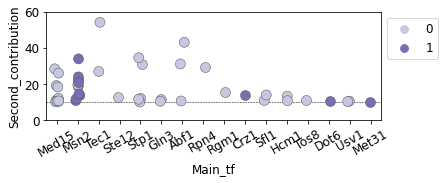

In [5]:
tp = '180'
wanted_exps = [13,14,16,25,26]
to_p = 100
thresh = 0.1
pattern = r'[0-9]'
all_tfs = np.unique([file.split('_')[0] for file in os.listdir(params.RES_PATH)])
matchers = ['OE','DBD','Context']
matching = [s for s in all_tfs if any(xs in s for xs in matchers)]
wanted_tfs = [x for x in all_tfs if x not in matching]
dep_df = pd.DataFrame()
for curr_tf in wanted_tfs:
    tf_files = [file for file in dp.find_tf_files(curr_tf) if int(file.split('.')[0].split('_')[2]) in wanted_exps]
    lib_nums = list(set([file.split('.')[0].split('_')[1] for file in tf_files]))
    for curr_lib in lib_nums:
        lib_info = dp.get_lib_info(curr_lib)
        lib_files = [i for i in tf_files if i.split('.')[0].split('_')[1]==str(curr_lib)]
        curr_exps = [i.split('.')[0].split('_')[2] for i in lib_files]
        res = lto.combine_2_exps(curr_tf, curr_lib, tp, curr_exps, norm_to=0)
        _,_,on_dict,off_dict,_,_ = lto.get_all_tf_motifs_wt_or_mut(curr_tf,lib_info,res.index)
        tf_pos,non_tf_pos = lto.get_tf_positions(lib_info,curr_tf)
        tf_on_ids = []
        for pos in tf_pos:
            tf_on_ids = tf_on_ids + on_dict[pos]
        pos_contribution = []
        for pos in non_tf_pos:
            pos_on_tf_off = np.setdiff1d(on_dict[pos],tf_on_ids)
            pos_off_tf_off = np.setdiff1d(off_dict[pos],tf_on_ids)
            pos_contribution.append(lto.convert_fc_to_occ(res.iloc[pos_on_tf_off].mean().mean() - res.iloc[pos_off_tf_off].mean().mean()))
        if pos_contribution:  
            max_val = np.max(pos_contribution)
            if np.sum(np.array(pos_contribution)>thresh)>0:
                main_tf_contribution = []
                mut_seq = lto.get_mut_var(curr_lib)
                for pos in tf_pos:
                    _,only_on_id = lto.get_values_by_wt_pos([pos],res,curr_lib)
                    main_tf_contribution.append(lto.convert_fc_to_occ((res.iloc[only_on_id].mean(axis=1).values-res.loc[mut_seq].mean())[0]))
                if len(tf_pos)>0:
                    main_tf_max_pos = tf_pos[np.argmax(main_tf_contribution)]
                tf2_max_pos = non_tf_pos[np.where(np.array(pos_contribution)>thresh)]
                impact_vals = np.array(pos_contribution)[np.array(pos_contribution)>thresh]
                for i,impact_pos in enumerate(tf2_max_pos):
                    if len(tf_pos)>0:
                        mot_dist = lto.get_min_dist_tf(curr_lib,curr_tf,main_tf_max_pos,impact_pos)
                    tf2 = re.sub(pattern, '', lib_info['mut_by_tf'][impact_pos].split('/')[0])
                    dep_df = pd.concat([dep_df,pd.DataFrame([curr_tf,tf2,curr_lib,main_tf_max_pos,impact_pos,mot_dist,impact_vals[i]*to_p]).T])
dep_df.reset_index(inplace=True,drop=True)    
dep_df.columns = ['Main_tf','Second_tf','Library','Main_pos','Second_pos','Distance','Second_contribution']
to_perc = 100
no_mot = 'Med15'
med15_val = 0
simil = []
for row in dep_df.index:
    curr_lib = dep_df.loc[row,:]['Library']
    curr_main_pos = dep_df.loc[row,:]['Main_pos']            
    curr_second_pos = dep_df.loc[row,:]['Second_pos']
    lib_info = dp.get_lib_info(curr_lib)
    lib_wt_seq = lib_info['wt_seq']
    mot_info = dp.get_motif_info_by_pos(curr_lib)
    main_tf = dep_df.loc[row,:]['Main_tf'][0:-1]
    if main_tf in no_mot:
        simil.append(0)
    else:
        second_tf_opts = mot_info.loc[mot_info['Pos']==curr_second_pos]
        second_id_in_info = np.argmax(second_tf_opts['Start'].values-second_tf_opts['End'].values)
        second_start = second_tf_opts.iloc[second_id_in_info,:]['Start']
        second_end = second_tf_opts.iloc[second_id_in_info,:]['End']
        second_mot = Seq(lib_wt_seq[second_start:second_end])
        second_mot_rc = Seq.reverse_complement(second_mot)
        main_tf_opts = mot_info.loc[mot_info['Pos']==curr_main_pos]
        main_tf_start = main_tf_opts.loc[main_tf_opts['TF'].str.contains(main_tf.upper())]['Start'].values[0]
        main_tf_end = main_tf_opts.loc[main_tf_opts['TF'].str.contains(main_tf.upper())]['End'].values[0]
        main_tf_mot = lib_wt_seq[main_tf_start:main_tf_end]
        main_mot_len = len(main_tf_mot)
        curr_max_sim = int(np.max([pairwise2.align.globalxx(Seq(main_tf_mot), second_mot)[0].score
                                   ,pairwise2.align.globalxx(Seq(main_tf_mot), second_mot_rc)[0].score]))
        curr_sim = main_mot_len-curr_max_sim
        if curr_sim==1:
            simil.append(1)
        else:
            simil.append(0)
dep_df['Similarity'] = simil
order = ['Med15','Msn2','Tec1','Ste12','Stp1','Gln3','Abf1','Rpn4','Rgm1','Crz1','Sfl1','Hcm1','Tos8','Dot6','Usv1','Met31']
fig,ax = plt.subplots(figsize=(6,2))
sns.stripplot(data=dep_df,x='Main_tf',y='Second_contribution',hue='Similarity',size=10,linewidth=0.5,palette="Purples",ax=ax,order=order)
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.axhline(10,color='k',linestyle='--',linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set_ylim(0,60)

## (G1) TF-TF pair correlation over libraries

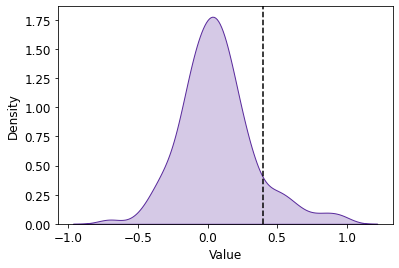

In [4]:
wanted_exps = [13,14,16,25]
val_unknown = -10
tp = '180'
thresh = -1
fin_df = pd.DataFrame()
for lib_num in range(32,97):
    curr_lib = dp.get_lib_info(lib_num)['gene']+'_'+str(lib_num)
    files = dp.find_lib_files(lib_num)
    rel_files = [file for file in files if int(file.split('.')[0].split('_')[-1]) in wanted_exps]
    tfs = []
    df = pd.DataFrame()
    for file in rel_files:
        tf,_,exp = file.split('.')[0].split('_')
        tfs.append(tf)
        curr_res = lto.norm_res_data(tf,lib_num,exp,0)
        curr_res_avg = curr_res.mean(axis=1)
        df = pd.concat([df,curr_res_avg],axis=1)
    df.columns = tfs
    df = df.drop(df.filter(regex='OE|DBD').columns,axis=1)
    df = df.corr()
    df = df.where(np.triu(np.ones(df.shape)).astype(bool))
    df = df.stack().reset_index()
    df.columns = ['Row','Column','Value']
    df = df.loc[(df['Row']==df['Column'])==False,:]
    # sns.histplot(df)
    df.sort_values(by='Value',ascending=False)
    df['lib'] = [curr_lib]*len(df)
    fin_df = pd.concat([fin_df,df])
fin_df = fin_df.loc[fin_df['Value']>thresh].sort_values(by='Value', ascending=False)
fin_df.reset_index(drop=True,inplace=True)
edv = []
tf_pairs = []
for i in range(len(fin_df)):
    tfa = (fin_df['Row'].iloc[i])
    tfb = (fin_df['Column'].iloc[i])
    tf_pairs.append('_'.join(list(np.sort([tfa,tfb]))))
    if len(ed_df.filter(regex=tfa.upper()).columns) + len(ed_df.filter(regex=tfb.upper()).columns) < 2:
        edv.append(val_unknown)
    else:
        edv.append(ed_df.loc[tfa.upper(),tfb.upper()])
fin_df['ed'] = edv
thresh = 0.4
sns.kdeplot(data=fin_df,x='Value',fill=True,color='#592a9c')
plt.axvline(thresh,c='k',linestyle='--')

## (G2) Top TF-TF library correlation

/tmp/ipykernel_91010/3780152658.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['Pair'] = pairs
/tmp/ipykernel_91010/3780152658.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


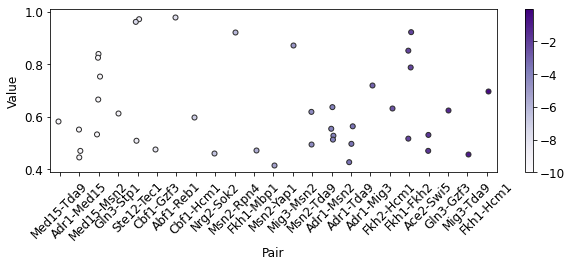

In [5]:
top_df = fin_df.loc[fin_df['Value']>thresh]
pairs = []
for tfa,tfb in zip(top_df['Row'].values,top_df['Column'].values):
    pair = np.sort([tfa,tfb])
    pairs.append('-'.join(pair))
top_df['Pair'] = pairs
order = (top_df.groupby('Pair').min()['ed']).sort_values().index
fig,ax = plt.subplots(1,1,figsize=(10,3))
sns.stripplot(data=top_df,x='Pair',y='Value',order=order,hue='ed',palette='Purples',linewidth=1,ax=ax)
plt.xticks(rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
norm = plt.Normalize(top_df['ed'].min(), top_df['ed'].max())
sm = plt.cm.ScalarMappable(cmap='Purples', norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm)

## (H) All tfs, all libraries cooperativity scores

/tmp/ipykernel_91010/773407073.py:79: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm, ticks =bins)


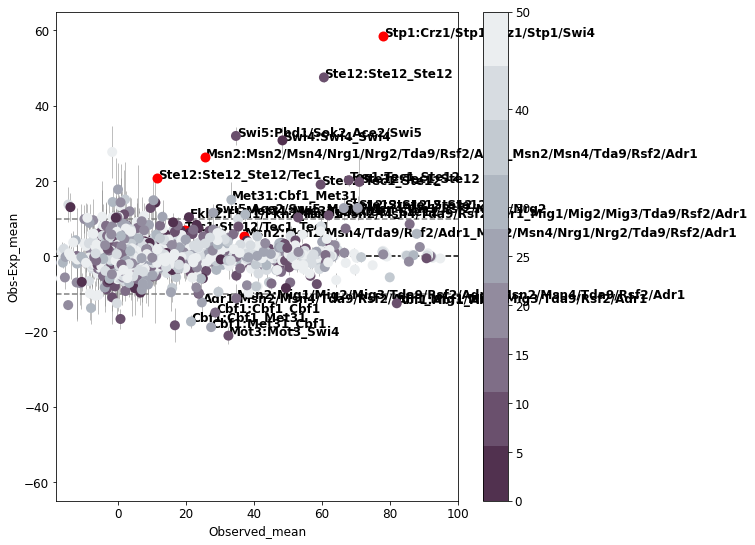

In [6]:
all_tf_coop.drop(all_tf_coop.query("TF=='Usv1'").index, inplace=True)
all_tf_coop.reset_index(drop=True,inplace=True)
control_df = pd.DataFrame()
redandent_controls_tfs = ['Msn2', 'Msn2', 'Stp1', 'Ste12', 'Tec1']
proms = ['Usv1', 'Usv1', 'Bap3', 'Pop3', 'Pop3']
combs = [['0_1'],['3_4'],['5_6'],['1_2'],['2_3']]
for cont_tf_i, cont_tf in enumerate(redandent_controls_tfs):
    curr_prom = proms[cont_tf_i]
    curr_comb = combs[cont_tf_i]
    curr_data = all_tf_coop.query("TF==@cont_tf & Gene==@curr_prom & Comb==@curr_comb")
    control_id = np.argmax(curr_data['Obs-Exp_mean'])
    relevant_row = curr_data.query("TF==@cont_tf").iloc[control_id,:].to_frame().T
    control_df = pd.concat([control_df, relevant_row])
    all_tf_coop.drop(relevant_row.index,inplace=True)

min_dist = 0
max_dist = 50
mid_dist = 30
jumps_small = 5
jumps_big = 10

min_vals = all_tf_coop['Min_dist'].values.copy()
bins = np.concatenate((np.arange(min_dist,mid_dist+jumps_small, jumps_small), 
                       np.arange(mid_dist+jumps_big,max_dist+jumps_big, jumps_big)))
min_vals[min_vals<min_dist] = min_dist
min_vals[min_vals>max_dist] = max_dist

for bin_i in range(len(bins)-1):
    low_bin = bins[bin_i]
    high_bin = bins[bin_i+1]
    bin_row_i = np.intersect1d(np.where(min_vals>low_bin)[0], np.where(min_vals<high_bin)[0])
    min_vals[bin_row_i] = high_bin
all_tf_coop['Min_dist'] = min_vals

color_palette = sns.color_palette("BuPu_r", len(bins), desat=.3)
norm = plt.Normalize(all_tf_coop['Min_dist'].min(), all_tf_coop['Min_dist'].max())
sm = plt.cm.ScalarMappable(cmap=matplotlib.colors.ListedColormap(sns.color_palette(color_palette).as_hex()), norm=norm)
sm.set_array([])

thresh = 10
obs_tresh = -18
fig,ax = plt.subplots(1,1,figsize=(9,9))

sns.scatterplot(data=control_df, x='Observed_mean', y='Obs-Exp_mean', s=100,
                zorder=20, color='red', linewidth=0, ax=ax)

for i in control_df.index:
    curr_line = control_df.loc[i, :]
    curr_val_coop = curr_line['Obs-Exp_mean']
    curr_val_obs = curr_line['Observed_mean']
    curr_txt = curr_line['TF'] + ':' +curr_line['Comb_tfs']
    plt.text(curr_val_obs+0.2,curr_val_coop, curr_txt, horizontalalignment='left', size='medium',
             color='black', weight='semibold')

sns.scatterplot(data=all_tf_coop, x='Observed_mean', y='Obs-Exp_mean', s=100,
                zorder=20, linewidth=0, hue='Min_dist', palette=color_palette, legend=None, ax=ax)
plt.errorbar(all_tf_coop['Observed_mean'], all_tf_coop['Obs-Exp_mean'], yerr=all_tf_coop['Obs-Exp_sem'],
             ecolor='grey',elinewidth=0.5,color='white', fmt='o')
ax.set_ylim(-65,65)
ax.set_xlim(obs_tresh,100)

ax.axline((0,0), slope=0, color='k', linestyle='--')
ax.axline((0,thresh), slope=0, color='grey', linestyle='--')
ax.axline((0,-thresh), slope=0, color='grey', linestyle='--')
# txt_ids = np.where((all_tf_coop['Obs-Exp_mean'] > thresh+5) | (all_tf_coop['Obs-Exp_mean'] < -thresh-5))[0]

coop_ids = np.where((all_tf_coop['Obs-Exp_mean'] > thresh) | (all_tf_coop['Obs-Exp_mean'] < -thresh))[0]
obs_ids = np.where(all_tf_coop['Observed_mean']>20)[0]
txt_ids = np.intersect1d(coop_ids ,obs_ids)


for i in txt_ids:
    curr_line = all_tf_coop.iloc[i, :]
    curr_val_coop = curr_line['Obs-Exp_mean']
    curr_val_obs = curr_line['Observed_mean']
    curr_txt = curr_line['TF'] + ':' +curr_line['Comb_tfs']
    plt.text(curr_val_obs+0.2,curr_val_coop, curr_txt, horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.figure.colorbar(sm, ticks =bins)